# О данном ноутбуке

В данном ноутбуке посмотрим на архитектуру модели ResNet50 и попробуем обучить ее на датасете [Tiny ImageNet](https://www.kaggle.com/c/tiny-imagenet)

# Часть 0 - Подготовка данных

In [1]:
! pip install -q kaggle

In [2]:
import kagglehub
import os

# Download latest version
os.environ["KAGGLEHUB_CACHE"] = "/content/kaggle"

path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")

print("Path to dataset files:", path)

100%|██████████| 474M/474M [00:24<00:00, 20.7MB/s]

Extracting files...


Path to dataset files: /content/kaggle/datasets/akash2sharma/tiny-imagenet/versions/1


Если вдруг путь будет отличаться от environ, то либо стоит попробовать удалить kaggle перейдя выше по директориям, либо поменять root_dir ниже

In [4]:
import os
import shutil

from sklearn.preprocessing import LabelEncoder

root_dir = "/content/kaggle/datasets/akash2sharma/tiny-imagenet/versions/1/tiny-imagenet-200"
#root_dir = "/kaggle/input/tiny-imagenet/tiny-imagenet-200"
train_dir = os.path.join(root_dir, "train/")
test_dir = os.path.join(root_dir, "test/")
val_dir = os.path.join(root_dir, "val/")

labels = os.listdir(train_dir)

In [ ]:
labels[:5]

['n02437312', 'n03976657', 'n07753592', 'n02769748', 'n02730930']

In [ ]:
print(os.listdir(val_dir))

['images', 'val_annotations.txt']


In [5]:
# Для правильной обработки данных подглядел сюда: https://www.kaggle.com/code/mariacvelandia/t3-cnn-tinyimagenet/notebook
# Однако далее нам потребуется еще все перевести в dataset а потом в DataLoader для торча

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

files_train = []
labels_train = []
for label in labels:
    for filename in os.listdir(train_dir + label + '/images/'):
        files_train.append(train_dir + label + '/images/' + filename)
        labels_train.append(label)


files_val = []
labels_val = []
for filename in os.listdir(val_dir + 'images/'):
    files_val.append(val_dir + 'images/' + filename)

val_df = pd.read_csv(val_dir + 'val_annotations.txt', sep='\t', names=["File", "Label", "X1", "Y1", "X2", "Y2"], usecols=["File", "Label"])
for f in files_val:
    l = val_df.loc[val_df['File'] == f[len(val_dir + 'images/'):]]['Label'].values[0]
    labels_val.append(l)

files_test = []
for filename in os.listdir(test_dir + 'images/'):
    files_test.append(test_dir + 'images/' + filename)
    files_test = sorted(files_test)
df_train=pd.DataFrame({"path":files_train, 'label':labels_train })
df_test=pd.DataFrame({"path":files_val, 'label':labels_val })

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, df, transform=None, label_encoder=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "label"]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.label_encoder is not None:
            label = self.label_encoder.transform([label])[0]

        return image, label


In [ ]:
# Для начала попробуем совсем базовые аугментации изображений

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
train_dataset = ImageDataset(df_train, transform=transform, label_encoder=encoder_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

val_dataset = ImageDataset(df_test, transform=transform, label_encoder=encoder_labels)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


# Часть 2 - архитектура ResNet-50

Сама Resnet-50 выглядит следующим образом:

![title](https://habrastorage.org/r/w1560/getpro/habr/upload_files/445/1f1/150/4451f11509ee37d5155e5d429a8e4a0a.png)

Сначала пропишем bottleneck-block. Почитать про него можно [здесь](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

In [9]:
import torch.nn as nn

class Bottleneck(nn.Module):
  expansion = 4 # увелич выход каналов

  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(Bottleneck, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

    self.relu = nn.ReLU(inplace=True)
    self.downsample = downsample

  def forward(self,x):
    identity = x # Тот самый residual который будем прибавлять

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)

    return out

In [10]:
# Ну а теперь сам класс ResNet

class Resnet(nn.Module):
  def __init__(self, block, layers, num_classes=200):
    super(Resnet, self).__init__()
    self.in_channels = 64

    # Самая превая свертка из картинки

    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, 64, layers[0])
    self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, blocks, stride=1):
    downsample = None
    if stride!=1 or self.in_channels != out_channels * block.expansion:
      downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels * block.expansion)
      )

    layers = []
    layers.append(block(self.in_channels, out_channels, stride, downsample))

    self.in_channels = out_channels * block.expansion

    for _ in range(1, blocks):

        layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x


# Часть 3 - обучение

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
def ResNet50(num_classes=200):
    return Resnet(Bottleneck, [3, 4, 6, 3], num_classes)

model = ResNet50().to(device)

In [13]:
import torch
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [14]:
# Для обучения я воспользуюсь самописным модулем (вовсе не реклама)
!pip install --upgrade pytorch_training_template

In [ ]:
import pytorch_training_template as py_pt

# UPD - забыл тут добавить scheduler, можете попробовать поправить
train_loss_log, train_metric_log, val_loss_log, val_metric_log =py_pt.train(
  model=model,
  optimizer=optimizer,
  n_epochs=50,
  train_loader=train_loader,
  val_loader=val_loader,
  device=device,
  loss_fn=nn.CrossEntropyLoss(),
  metric_fn=py_pt.accuracy,
  checkpoint_path="resnet50_best.pt",
  resume=False,
  metric="val_metric",
  save_last=False,
  use_amp=True
)

/usr/local/lib/python3.12/dist-packages/pytorch_training_template/device.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()



Epoch 1/50


 train loss: 3.4233, train acc: 0.2242
 val loss: 3.6279, val acc: 0.1924
Saved new best model (val_metric=0.1924)

Epoch 2/50


 train loss: 3.3409, train acc: 0.2367
 val loss: 3.5609, val acc: 0.2042
Saved new best model (val_metric=0.2042)

Epoch 3/50


 train loss: 3.2758, train acc: 0.2497
 val loss: 3.5768, val acc: 0.2124
Saved new best model (val_metric=0.2124)

Epoch 4/50


 train loss: 3.2237, train acc: 0.2575
 val loss: 3.6501, val acc: 0.1960

Epoch 5/50


 train loss: 3.1774, train acc: 0.2678
 val loss: 3.5881, val acc: 0.2135
Saved new best model (val_metric=0.2135)

Epoch 6/50


 train loss: 3.1436, train acc: 0.2742
 val loss: 3.5969, val acc: 0.2175
Saved new best model (val_metric=0.2175)

Epoch 7/50


 train loss: 3.1157, train acc: 0.2779
 val loss: 3.5136, val acc: 0.2167

Epoch 8/50


 train loss: 3.0872, train acc: 0.2847
 val loss: 3.2967, val acc: 0.2489
Saved new best model (val_metric=0.2489)

Epoch 9/50


 train loss: 3.0621, train acc: 0.2888
 val loss: 3.4311, val acc: 0.2374

Epoch 10/50


 train loss: 3.0502, train acc: 0.2912
 val loss: 3.3283, val acc: 0.2493
Saved new best model (val_metric=0.2493)

Epoch 11/50


 train loss: 3.0256, train acc: 0.2949
 val loss: 3.3404, val acc: 0.2433

Epoch 12/50


 train loss: 3.0188, train acc: 0.2971
 val loss: 3.2326, val acc: 0.2691
Saved new best model (val_metric=0.2691)

Epoch 13/50


 train loss: 3.0052, train acc: 0.3013
 val loss: 3.2280, val acc: 0.2672

Epoch 14/50


 train loss: 2.9949, train acc: 0.3019
 val loss: 3.3939, val acc: 0.2477

Epoch 15/50


 train loss: 2.9852, train acc: 0.3050
 val loss: 3.2279, val acc: 0.2652

Epoch 16/50


 train loss: 2.9735, train acc: 0.3055
 val loss: 3.3208, val acc: 0.2531

Epoch 17/50


 train loss: 2.9711, train acc: 0.3063
 val loss: 3.4051, val acc: 0.2410

Epoch 18/50


 train loss: 2.9662, train acc: 0.3074
 val loss: 3.2847, val acc: 0.2639

Epoch 19/50


 train loss: 2.9512, train acc: 0.3109
 val loss: 3.2853, val acc: 0.2643

Epoch 20/50


 train loss: 2.9500, train acc: 0.3086
 val loss: 3.3983, val acc: 0.2427

Epoch 21/50


KeyboardInterrupt: 

Во-первых замечу что тут сохранилась часть обучения предыдущей модели (20 эпох), потому что качество с первой эпохи 0.22

Как видим мы очень скоро вышли на плато обучения и скоро начался бы overfitting - уже есть симптомы на эпохах 12-18, поэтому обучение прекратили (А если точнее, то эпоха 32-38 т.к. сохранились веса предыдущего прохода обучения)

Однако, даже так, мы смогли выбить качество около 25%, что уже является неплохим результатом, т.к. мы обучаем довольно тяжелую модель на весьма маленьком датасете по сравнению с исходным

Стоит также заметить, что мы практически не использовали аугментации изображений и есть еще несколько соображений по которым можно улучшить нашу модель. К делу!

# Часть 4 - Пробуем улучшить результаты

In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [8]:
train_dataset = ImageDataset(df_train, transform=train_transform, label_encoder=encoder_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

val_dataset = ImageDataset(df_test, transform=val_transform, label_encoder=encoder_labels)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
model_bet = ResNet50().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_bet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=20
)

In [ ]:
import pytorch_training_template as py_pt

train_loss_log, train_metric_log, val_loss_log, val_metric_log =py_pt.train(
  model=model_bet,
  optimizer=optimizer,
  n_epochs=20,
  scheduler=scheduler,
  train_loader=train_loader,
  val_loader=val_loader,
  device=device,
  loss_fn=nn.CrossEntropyLoss(),
  metric_fn=py_pt.accuracy,
  checkpoint_path="resnet50_best.pt",
  resume=False,
  metric="val_metric",
  save_last=False,
  use_amp=True
)

/usr/local/lib/python3.12/dist-packages/pytorch_training_template/device.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()



Epoch 1/20


 train loss: 5.3228, train acc: 0.0082
 val loss: 5.0842, val acc: 0.0153
Saved new best model (val_metric=0.0153)

Epoch 2/20


 train loss: 5.0009, train acc: 0.0219
 val loss: 4.8306, val acc: 0.0381
Saved new best model (val_metric=0.0381)

Epoch 3/20


 train loss: 4.6516, train acc: 0.0542
 val loss: 4.4315, val acc: 0.0760
Saved new best model (val_metric=0.0760)

Epoch 4/20


 train loss: 4.3710, train acc: 0.0853
 val loss: 4.2557, val acc: 0.1050
Saved new best model (val_metric=0.1050)

Epoch 5/20


 train loss: 4.2047, train acc: 0.1080
 val loss: 4.1183, val acc: 0.1136
Saved new best model (val_metric=0.1136)

Epoch 6/20


 train loss: 4.0908, train acc: 0.1225
 val loss: 4.8690, val acc: 0.0762

Epoch 7/20


 train loss: 3.9925, train acc: 0.1378
 val loss: 4.0945, val acc: 0.1308
Saved new best model (val_metric=0.1308)

Epoch 8/20


 train loss: 3.9111, train acc: 0.1488
 val loss: 3.9203, val acc: 0.1496
Saved new best model (val_metric=0.1496)

Epoch 9/20


 train loss: 3.8180, train acc: 0.1634
 val loss: 3.6106, val acc: 0.1897
Saved new best model (val_metric=0.1897)

Epoch 10/20


 train loss: 3.7272, train acc: 0.1781
 val loss: 3.7003, val acc: 0.1808

Epoch 11/20


 train loss: 3.6286, train acc: 0.1946
 val loss: 3.6580, val acc: 0.1938
Saved new best model (val_metric=0.1938)

Epoch 12/20


 train loss: 3.5271, train acc: 0.2105
 val loss: 3.7164, val acc: 0.1853

Epoch 13/20


 train loss: 3.4162, train acc: 0.2309
 val loss: 3.4736, val acc: 0.2261
Saved new best model (val_metric=0.2261)

Epoch 14/20


 train loss: 3.2904, train acc: 0.2524
 val loss: 3.3634, val acc: 0.2391
Saved new best model (val_metric=0.2391)

Epoch 15/20


 train loss: 3.1563, train acc: 0.2765
 val loss: 3.0690, val acc: 0.2951
Saved new best model (val_metric=0.2951)

Epoch 16/20


 train loss: 3.0149, train acc: 0.3021
 val loss: 2.9691, val acc: 0.3155
Saved new best model (val_metric=0.3155)

Epoch 17/20


 train loss: 2.8528, train acc: 0.3328
 val loss: 2.9274, val acc: 0.3249
Saved new best model (val_metric=0.3249)

Epoch 18/20


 train loss: 2.6827, train acc: 0.3661
 val loss: 2.6893, val acc: 0.3659
Saved new best model (val_metric=0.3659)

Epoch 19/20


 train loss: 2.5246, train acc: 0.3973
 val loss: 2.6582, val acc: 0.3751
Saved new best model (val_metric=0.3751)

Epoch 20/20


 train loss: 2.4102, train acc: 0.4220
 val loss: 2.5340, val acc: 0.3984
Saved new best model (val_metric=0.3984)


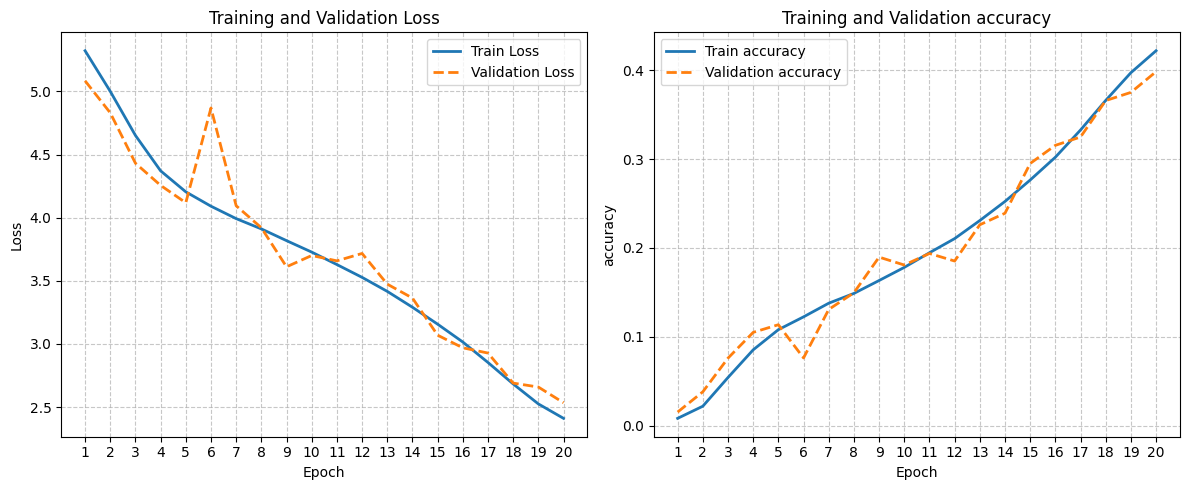

In [ ]:
py_pt.plot_reses(train_loss_log, train_metric_log, val_loss_log, val_metric_log, metric_name="accuracy")

Как видим нам удалось значительно повысить качество нашей модели, потому что благодаря более сложным аугментациями она начала выучивать более сложные зависимости

Попробуем обучить еще на 10 дополнительных эпохах

In [ ]:
import importlib, pytorch_training_template.training as t
importlib.reload(t)

<module 'pytorch_training_template.training' from '/usr/local/lib/python3.12/dist-packages/pytorch_training_template/training.py'>

In [ ]:
import pytorch_training_template as py_pt

train_loss_log, train_metric_log, val_loss_log, val_metric_log =py_pt.train(
  model=model_bet,
  optimizer=optimizer,
  n_epochs=10,
  scheduler=scheduler,
  train_loader=train_loader,
  val_loader=val_loader,
  device=device,
  loss_fn=nn.CrossEntropyLoss(),
  metric_fn=py_pt.accuracy,
  checkpoint_path="resnet50_best.pt",
  resume=True,
  metric="val_metric",
  save_last=False,
  use_amp=True
)

/usr/local/lib/python3.12/dist-packages/pytorch_training_template/device.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()


Loaded checkpoint from previous epochs: 20, best_score=0.3984

Epoch 21/10


 train loss: 2.3798, train acc: 0.4294
 val loss: 2.5365, val acc: 0.3995
Saved new best model (val_metric=0.3995)

Epoch 22/10


 train loss: 2.3804, train acc: 0.4256
 val loss: 2.5596, val acc: 0.3953

Epoch 23/10


 train loss: 2.4385, train acc: 0.4156
 val loss: 2.6402, val acc: 0.3886

Epoch 24/10


 train loss: 2.5823, train acc: 0.3837
 val loss: 2.6555, val acc: 0.3807

Epoch 25/10


 train loss: 2.7586, train acc: 0.3486
 val loss: 2.9754, val acc: 0.3169

Epoch 26/10


 train loss: 2.9203, train acc: 0.3189
 val loss: 2.9110, val acc: 0.3237

Epoch 27/10


 train loss: 3.0234, train acc: 0.2988
 val loss: 3.0260, val acc: 0.3054

Epoch 28/10


KeyboardInterrupt: 

Ну все, как видим при дальнейшем обучении у модели уже пошел overfitting сильный - качество серьезно просело как на train, так и на валидации.

В целом нам удалось выбить accuracy 40% на лучшей итерации, что можно считать успехом, т.к. мы обучали весьма тяжелую модель на довольно маленьком датасете

# Часть 5 - Pre-trained

В данном разделе попробуем взять уже предобученную модель и дообучить ее для нашего датасета. В частности, ради эксперимента будем проводить полный fine-tuning, то есть размораживать все веса модели, а не только последний слой. Потом, возможно, помотрим как модель себя будет вести при обучении только последнего слоя

In [15]:
import torchvision.models as models

resnet50 = models.resnet50(pretrained=True)

num_features = resnet50.fc.in_features

num_features

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


2048

In [ ]:
# Нужно поменять последний слой для нашей задачи

resnet50.fc = nn.Linear(num_features, 200)
resnet50 = resnet50.to(device)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
optimizer = optim.SGD(resnet50.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=5
)

In [ ]:
import pytorch_training_template as py_pt

train_loss_log, train_metric_log, val_loss_log, val_metric_log =py_pt.train(
  model=resnet50,
  optimizer=optimizer,
  n_epochs=5,
  scheduler=scheduler,
  train_loader=train_loader,
  val_loader=val_loader,
  device=device,
  loss_fn=nn.CrossEntropyLoss(),
  metric_fn=py_pt.accuracy,
  checkpoint_path="resnet50_pre_best.pt",
  resume=True,
  metric="val_metric",
  save_last=False,
  use_amp=True
)

Loaded checkpoint from previous epochs: 15, best_score=0.5320

Epoch 16/5


 train loss: 2.1652, train acc: 0.4862
 val loss: 1.9285, val acc: 0.5322
Saved new best model (val_metric=0.5322)

Epoch 17/5


 train loss: 2.1605, train acc: 0.4866
 val loss: 1.9268, val acc: 0.5321

Epoch 18/5


 train loss: 2.1509, train acc: 0.4885
 val loss: 1.9017, val acc: 0.5378
Saved new best model (val_metric=0.5378)

Epoch 19/5


 train loss: 2.1152, train acc: 0.4936
 val loss: 1.8661, val acc: 0.5439
Saved new best model (val_metric=0.5439)

Epoch 20/5


 train loss: 2.0725, train acc: 0.5005
 val loss: 1.8424, val acc: 0.5492
Saved new best model (val_metric=0.5492)


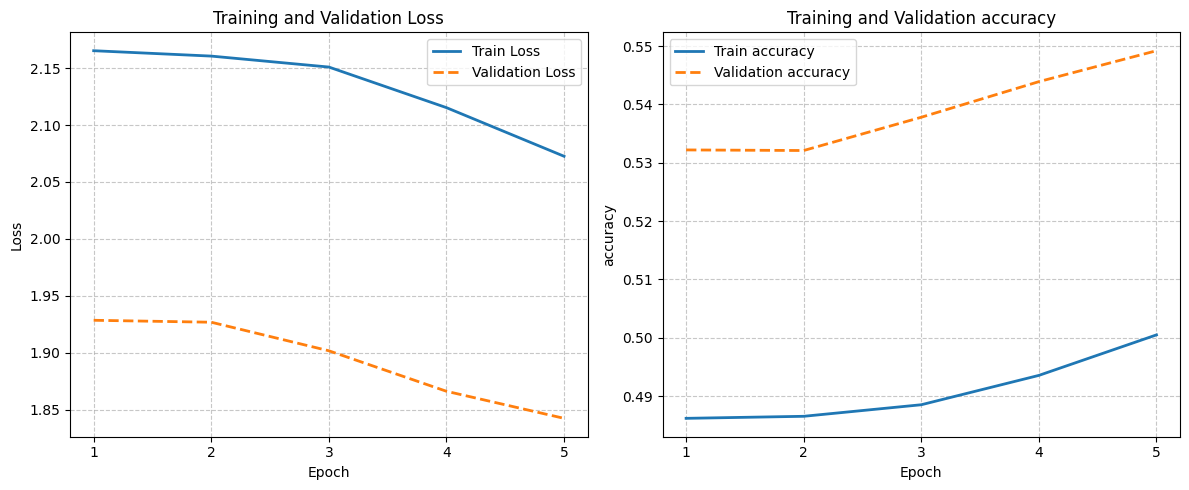

In [ ]:
py_pt.plot_reses(train_loss_log, train_metric_log, val_loss_log, val_metric_log, metric_name="accuracy")

Как видим нам удалось повысить качество еще на 10% при полном fine-tuning

# Часть 6 - Pre-Trained (разморозим только последний слой)

In [16]:
resnet_last = models.resnet50(weights="IMAGENET1K_V1")
num_classes = 200
resnet_last.fc = nn.Linear(resnet_last.fc.in_features, num_classes)

resnet_last.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
for param in resnet_last.parameters():
    param.requires_grad = False

# оставляем только последний слой
for param in resnet_last.fc.parameters():
    param.requires_grad = True

In [18]:
trainable_layers = [name for name, param in resnet_last.named_parameters() if param.requires_grad]
print("Обучаемые слои:", trainable_layers)

Обучаемые слои: ['fc.weight', 'fc.bias']


In [19]:
optimizer = optim.SGD(resnet_last.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10
)

In [20]:
import pytorch_training_template as py_pt

train_loss_log, train_metric_log, val_loss_log, val_metric_log =py_pt.train(
  model=resnet_last,
  optimizer=optimizer,
  n_epochs=10,
  scheduler=scheduler,
  train_loader=train_loader,
  val_loader=val_loader,
  device=device,
  loss_fn=nn.CrossEntropyLoss(),
  metric_fn=py_pt.accuracy,
  checkpoint_path="resnet_last_best.pt",
  resume=False,
  metric="val_metric",
  save_last=False,
  use_amp=True
)

/usr/local/lib/python3.12/dist-packages/pytorch_training_template/device.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return torch.cuda.amp.GradScaler()



Epoch 1/10


 train loss: 4.5620, train acc: 0.1228
 val loss: 3.6729, val acc: 0.2595
Saved new best model (val_metric=0.2595)

Epoch 2/10


 train loss: 3.9191, train acc: 0.1999
 val loss: 3.2977, val acc: 0.3050
Saved new best model (val_metric=0.3050)

Epoch 3/10


 train loss: 3.7370, train acc: 0.2190
 val loss: 3.1973, val acc: 0.3233
Saved new best model (val_metric=0.3233)

Epoch 4/10


 train loss: 3.6529, train acc: 0.2292
 val loss: 3.1480, val acc: 0.3264
Saved new best model (val_metric=0.3264)

Epoch 5/10


 train loss: 3.5976, train acc: 0.2367
 val loss: 3.1446, val acc: 0.3258

Epoch 6/10


 train loss: 3.5621, train acc: 0.2413
 val loss: 3.1386, val acc: 0.3302
Saved new best model (val_metric=0.3302)

Epoch 7/10


 train loss: 3.5337, train acc: 0.2451
 val loss: 3.0940, val acc: 0.3351
Saved new best model (val_metric=0.3351)

Epoch 8/10


 train loss: 3.5202, train acc: 0.2474
 val loss: 3.0406, val acc: 0.3396
Saved new best model (val_metric=0.3396)

Epoch 9/10


 train loss: 3.5111, train acc: 0.2494
 val loss: 3.0484, val acc: 0.3413
Saved new best model (val_metric=0.3413)

Epoch 10/10


 train loss: 3.5097, train acc: 0.2477
 val loss: 3.0899, val acc: 0.3336


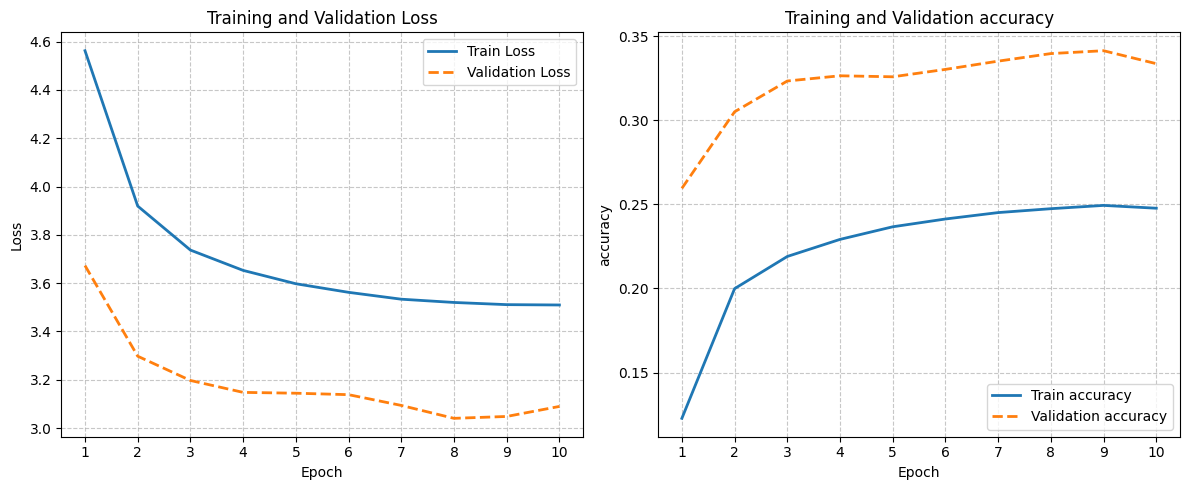

In [21]:
py_pt.plot_reses(train_loss_log, train_metric_log, val_loss_log, val_metric_log, metric_name="accuracy")

Как видим при таком обучении даже за 10 эпох наша модель уже приблизилась к accuracy 35%, далее можно было бы пробовать разморозить отдельлные блоки модели, но это уже я оставлю как упражнение тому, кто читает этот ноутбук.

Таким образом в рамках данного ноутбука мы с нуля обучили модель архитектуры ResNet, а также поработали с уже предобученными версиямим!